In [1]:
%load_ext autoreload
%autoreload 2

from modules.negative_set import generate_negative_set, get_box_parameters
from modules import data, models, descriptor_vector, validation, selection
from modules.selection import try_classifiers, try_params
import numpy as np
from skimage.transform import resize
import pickle
from pprint import pprint as pp

In [2]:
# Store
store = []

In [3]:
# Load data
full_images = data.load_images()
full_labels = data.load_labels()

In [70]:
# Global Params
OFFSET = 0
LIMIT = None
NEG_SIZE = 1500
TRAIN_RATE = 0.75

In [71]:
# Limit if needed
if LIMIT:
    images = full_images[OFFSET:OFFSET+LIMIT]
    labels = full_labels[full_labels[:,0] <= OFFSET+LIMIT]
    labels = labels[labels[:,0] > OFFSET]
else:
    images = full_images
    labels = full_labels
print(f"Using {len(images)}/{len(full_images)} images & {len(labels)}/{len(full_labels)} labels")

Using 1000/1000 images & 1284/1284 labels


In [72]:
# Label sets
print(f"Generating {NEG_SIZE} negatives...")
negatives = generate_negative_set(images, labels, set_size=NEG_SIZE)

print("Creating train & validation sets with negatives...")
all_labels = np.concatenate([labels, negatives])
train_labels, valid_labels = label_sets = data.train_valid_sets(len(images), all_labels, TRAIN_RATE)
print(f"Train: {len(np.unique(train_labels[:,0]))}, Valid: {len(np.unique(valid_labels[:,0]))}")

Generating 1500 negatives...
Creating train & validation sets with negatives...
Train: 750, Valid: 250


In [73]:
# Global params
only_one_training = False
limit_score = 0.5
slide_step = (60,50)
downscale_step = 30
box_size = (150, 90)

# Model
CLASSIFIER = 'random_forest'
MODEL_PARAMS = {
    'n_estimators': 50,
    'class_weight': { -1: 1, 1: 1.2}
}
VECTORIZATION_PARAMS = {
    'vectorize': descriptor_vector.hog,
    'vectorize_args': [6],
} 

In [75]:
# ( 1 ) --- Single --- Train, predict, validate
clf = models.create_model(CLASSIFIER, MODEL_PARAMS)
kwargs = { 'limit_score': limit_score, 'slide_step': slide_step, 'downscale_step': downscale_step }

print("Training...")
train_results, debug_tr = models.train(clf, images, box_size, train_labels, **VECTORIZATION_PARAMS,
                             only_one_training=only_one_training, **kwargs)

print("Predicting with windows...")
valid_indexes = np.unique(valid_labels[:,0]) - 1
predictions = models.predict(clf, images, box_size, **VECTORIZATION_PARAMS, only=valid_indexes, **kwargs)

results = validation.rate_predictions(predictions, valid_labels)
print("Done")

print("\n------\n")
if results not in store: store.append(results)
pp(results)

Training...
First training...




Predicting windows:   0%|                                                                                                                                          | 0/1000 [00:00<?, ?it/s]

Predicting windows:   0%|▏                                                                                                                                 | 1/1000 [00:00<11:20,  1.47it/s]

Predicting windows:   0%|▎                                                                                                                                 | 2/1000 [00:00<09:17,  1.79it/s]

Predicting windows:   0%|▍                                                                                                                                 | 3/1000 [00:01<09:22,  1.77it/s]

Predicting windows:   0%|▌                                                                                                                                 | 4/1000 [00:02<09:31,  1.74it/s]

Predicting windows:   0%|▋                      

426 Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.




Predicting windows:  43%|██████████████████████████████████████████████████████▉                                                                         | 429/1000 [02:54<03:32,  2.69it/s]

Predicting windows:  43%|███████████████████████████████████████████████████████                                                                         | 430/1000 [02:54<04:04,  2.33it/s]

Predicting windows:  43%|███████████████████████████████████████████████████████▏                                                                        | 431/1000 [02:55<04:21,  2.17it/s]

Predicting windows:  43%|███████████████████████████████████████████████████████▎                                                                        | 432/1000 [02:55<03:56,  2.40it/s]

Predicting windows:  43%|███████████████████████████████████████████████████████▌                                                                        | 434/1000 [02:56<03:24,  2.77it/s]

Predicting windows:  44%|███████████████████████

Adding 125 false positives / 544 predictions
Second training...
Predicting with windows...




Predicting windows:   0%|                                                                                                                                          | 0/1000 [00:00<?, ?it/s]

Predicting windows:   1%|█▏                                                                                                                                | 9/1000 [00:01<02:05,  7.92it/s]

Predicting windows:   1%|█▍                                                                                                                               | 11/1000 [00:02<04:10,  3.95it/s]

Predicting windows:   1%|█▋                                                                                                                               | 13/1000 [00:02<04:24,  3.74it/s]

Predicting windows:   2%|██▎                                                                                                                              | 18/1000 [00:03<04:08,  3.96it/s]

Predicting windows:   2%|██▌                    

715 Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.




Predicting windows:  72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 716/1000 [02:36<00:41,  6.86it/s]

Predicting windows:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 720/1000 [02:36<00:36,  7.64it/s]

Predicting windows:  72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 724/1000 [02:37<00:41,  6.73it/s]

Predicting windows:  73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 727/1000 [02:37<00:48,  5.62it/s]

Predicting windows:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 730/1000 [02:38<00:53,  5.04it/s]

Predicting windows:  73%|███████████████████████

Done

------

{'false_pos': 5,
 'missing_predictions': 238,
 'no_faces': 329,
 'no_images': 250,
 'no_predictions': 92,
 'true_pos': 87}


(184, 449, 3)
(154, 375, 3)


SyntaxError: 'return' outside function (<ipython-input-101-2dfd24f949a8>, line 10)

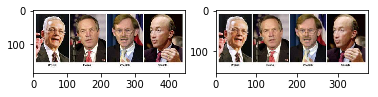

In [101]:
from modules.window import sliding_windows, downscale_image
img = debug_tr[0][1]
box_h, box_l = box_size
gen = list(downscale_image(img, step=downscale_step, min_height=box_h, min_width=box_l))

for i in gen:
    print(i.shape)
imshow_collection(gen)
#imshow(gen[2])
return None

x = debug_tr[0]
h, l = img.shape[:2]
print(sliding_windows(img, box_size, slide_step, downscale_step))

print(box_size, slide_step, downscale_step)
print(x[3])
print(img.shape)
#imshow(img)

In [106]:
ini_img_h, ini_img_l = img.shape[:2]
step_h, step_l = slide_step
box_h, box_l = box_size
if step_h >= box_h or step_l >= box_l:
    raise ValueError("The steps must be less than the box size")

coordinates = []
windows = []
for scaled_img in downscale_image(img, step=downscale_step, min_height=box_h, min_width=box_l):
    img_h, img_l = scaled_img.shape[:2]

    r_h = img_h / ini_img_h
    r_l = img_l / ini_img_l

    for x in range(0, img_h, step_h):
        for y in range(0, img_l, step_l):
            
            #print(x + box_h, ini_img_h, x + box_h < ini_img_h)
            if x  + box_h < img_h and y + box_l < img_l:
                window = scaled_img[x:x+box_h, y:y+box_l]

                # Window is at box_size for classification
                # but coordinates is not for detections
                coordinates.append([ x/r_h, y/r_l, box_h/r_h, box_l/r_l ])
                windows.append(window)


In [107]:
len(windows)

14

In [34]:
# ( 1bis ) --- Single --- Train, predict, validate
clf = models.create_model(CLASSIFIER, MODEL_PARAMS)
kwargs = { 'limit_score': limit_score, 'slide_step': slide_step, 'downscale_step': downscale_step }

print("Training...")
train_results = models.train(clf, images, box_size, train_labels, **VECTORIZATION_PARAMS,
                             only_one_training=only_one_training, **kwargs)

Training...
First training...


Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  2.21it/s]


Adding 10 false positives / 61 predictions
Second training...


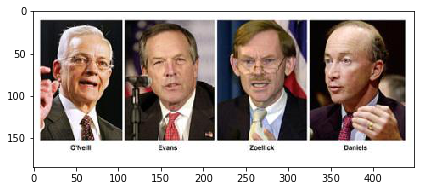

In [51]:
imshow(images[426])

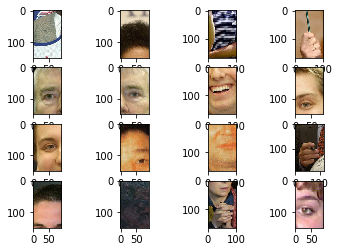

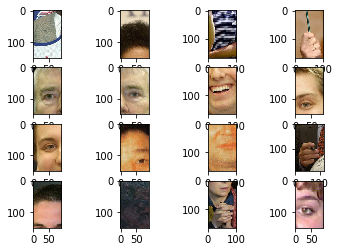

In [32]:
from skimage.io import imshow_collection
imgs = []
for falpos in train_results:
    img_id = falpos[0]
    x,y,h,l = falpos[1:5]
    img = images[img_id-1]
    imgs.append(img[x:x+h,y:y+l])
imshow_collection(imgs)

In [96]:
# ( 2 ) --- Multiple --- Try multiple params
clf_name = 'random_forest'
global_params = {
    # General
    'box_size': (150, 90),

    'n_estimators': 50,
    'class_weight': { -1: 1, 1: 1.2},

    'vectorization_params': {
        'vectorize': descriptor_vector.hog,
        'vectorize_args': [6],
    },
}

kwargs = {
    'limit_score': 0.5,
    'slide_step': (60,50),
    'downscale_step': 30,
    'only_one_training': True,
}

changing_params = {
    'box_size': [
        (150, 90),
        (160, 100),
        (170, 110),
        (170, 120),
    ]
}

results = try_params(images, label_sets, clf_name, global_params, changing_params, **kwargs)
print("\n------\n")
if results not in store: store.append(results)
pp(results)

## Trying parameter `box_size`...
### with value `(150, 90)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  1.28it/s]

### with value `(160, 100)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  1.09it/s]

### with value `(170, 110)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  1.43it/s]

### with value `(170, 120)`
First training...



Predicting windows: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  1.13it/s]


------

{'classifier': 'random_forest',
 'global_params': {'class_weight': {-1: 1, 1: 1.2}, 'n_estimators': 50},
 'results': [{'name': 'box_size',
              'result': {'false_pos': 11,
                         'missing_predictions': 25,
                         'no_faces': 55,
                         'no_images': 40,
                         'no_predictions': 39,
                         'true_pos': 28},
              'value': (150, 90)},
             {'name': 'box_size',
              'result': {'false_pos': 9,
                         'missing_predictions': 25,
                         'no_faces': 55,
                         'no_images': 40,
                         'no_predictions': 36,
                         'true_pos': 27},
              'value': (160, 100)},
             {'name': 'box_size',
              'result': {'false_pos': 8,
                         'missing_predictions': 28,
                         'no_faces': 55,
                         'no_images': 40,
      